# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana0700s3_long"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(4927, 32, 32, 3)
(4927, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(16, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 100
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
616/616 [==============================] - 5s 9ms/step - loss: 0.1376 - accuracy: 0.8638 - val_loss: 0.0175 - val_accuracy: 0.9807
Epoch 2/100
616/616 [==============================] - 5s 8ms/step - loss: 0.0190 - accuracy: 0.9612 - val_loss: 0.0160 - val_accuracy: 0.9665
Epoch 3/100
616/616 [==============================] - 5s 8ms/step - loss: 0.0117 - accuracy: 0.9724 - val_loss: 0.0105 - val_accuracy: 0.9878
Epoch 4/100
616/616 [==============================] - 5s 8ms/step - loss: 0.0081 - accuracy: 0.9756 - val_loss: 0.0063 - val_accuracy: 0.9848
Epoch 5/100
616/616 [==============================] - 5s 8ms/step - loss: 0.0064 - accuracy: 0.9787 - val_loss: 0.0033 - val_accuracy: 0.9919
Epoch 6/100
616/616 [==============================] - 5s 8ms/step - loss: 0.0045 - accuracy: 0.9803 - val_loss: 0.0038 - val_accuracy: 0.9675
Epoch 7/100
616/616 [==============================] - 5s 8ms/step

616/616 [==============================] - 5s 8ms/step - loss: 5.5079e-04 - accuracy: 0.9945 - val_loss: 4.5877e-04 - val_accuracy: 0.9990
Epoch 55/100
616/616 [==============================] - 5s 8ms/step - loss: 5.1181e-04 - accuracy: 0.9959 - val_loss: 4.7196e-04 - val_accuracy: 0.9980
Epoch 56/100
616/616 [==============================] - 5s 8ms/step - loss: 5.2506e-04 - accuracy: 0.9963 - val_loss: 3.6730e-04 - val_accuracy: 0.9990
Epoch 57/100
616/616 [==============================] - 5s 8ms/step - loss: 5.2096e-04 - accuracy: 0.9959 - val_loss: 7.2295e-04 - val_accuracy: 0.9817
Epoch 58/100
616/616 [==============================] - 5s 8ms/step - loss: 4.9434e-04 - accuracy: 0.9968 - val_loss: 6.5088e-04 - val_accuracy: 0.9909
Epoch 59/100
616/616 [==============================] - 5s 8ms/step - loss: 5.2566e-04 - accuracy: 0.9945 - val_loss: 3.3086e-04 - val_accuracy: 0.9970
Epoch 60/100
616/616 [==============================] - 5s 8ms/step - loss: 4.8836e-04 - accuracy: 0.

### Step 1: Learing result
 
* Visualization of the training and validation results

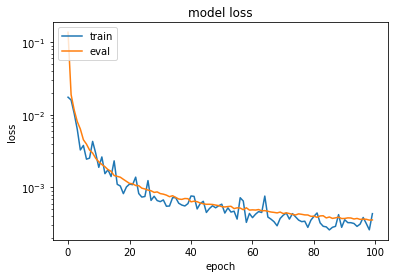

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 600
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/600
616/616 [==============================] - 5s 9ms/step - loss: 0.0588 - accuracy: 0.9111 - val_loss: 0.0161 - val_accuracy: 0.9706
Epoch 2/600
616/616 [==============================] - 5s 9ms/step - loss: 0.0148 - accuracy: 0.9608 - val_loss: 0.0120 - val_accuracy: 0.9655
Epoch 3/600
616/616 [==============================] - 6s 9ms/step - loss: 0.0092 - accuracy: 0.9734 - val_loss: 0.0059 - val_accuracy: 0.9858
Epoch 4/600
616/616 [==============================] - 5s 9ms/step - loss: 0.0060 - accuracy: 0.9740 - val_loss: 0.0043 - val_accuracy: 0.9797
Epoch 5/600
616/616 [==============================] - 5s 9ms/step - loss: 0.0052 - accuracy: 0.9815 - val_loss: 0.0044 - val_accuracy: 0.9868
Epoch 6/600
616/616 [==============================] - 5s 9ms/step - loss: 0.0042 - accuracy: 0.9805 - val_loss: 0.0042 - val_accuracy: 0.9787
Epoch 7/600
616/616 [==============================] - 6s 9ms/step - loss: 0.0037 - accuracy: 0.9830 - val_loss: 0.0031 - val_accuracy: 0.9787

616/616 [==============================] - 5s 9ms/step - loss: 8.7184e-04 - accuracy: 0.9921 - val_loss: 9.0899e-04 - val_accuracy: 0.9949
Epoch 58/600
616/616 [==============================] - 6s 9ms/step - loss: 8.6762e-04 - accuracy: 0.9941 - val_loss: 7.0406e-04 - val_accuracy: 0.9980
Epoch 59/600
616/616 [==============================] - 5s 9ms/step - loss: 8.3704e-04 - accuracy: 0.9931 - val_loss: 7.4070e-04 - val_accuracy: 0.9980
Epoch 60/600
616/616 [==============================] - 5s 9ms/step - loss: 8.4388e-04 - accuracy: 0.9935 - val_loss: 0.0010 - val_accuracy: 0.9949
Epoch 61/600
616/616 [==============================] - 6s 9ms/step - loss: 8.3195e-04 - accuracy: 0.9933 - val_loss: 8.1939e-04 - val_accuracy: 0.9959
Epoch 62/600
616/616 [==============================] - 6s 9ms/step - loss: 8.3028e-04 - accuracy: 0.9949 - val_loss: 8.0567e-04 - val_accuracy: 0.9980
Epoch 63/600
616/616 [==============================] - 6s 10ms/step - loss: 8.7026e-04 - accuracy: 0.992

Epoch 111/600
616/616 [==============================] - 5s 9ms/step - loss: 6.4193e-04 - accuracy: 0.9937 - val_loss: 5.8191e-04 - val_accuracy: 0.9980
Epoch 112/600
616/616 [==============================] - 5s 9ms/step - loss: 6.1932e-04 - accuracy: 0.9937 - val_loss: 5.4418e-04 - val_accuracy: 0.9970
Epoch 113/600
616/616 [==============================] - 5s 9ms/step - loss: 6.5691e-04 - accuracy: 0.9945 - val_loss: 6.5820e-04 - val_accuracy: 0.9970
Epoch 114/600
616/616 [==============================] - 5s 9ms/step - loss: 6.5944e-04 - accuracy: 0.9943 - val_loss: 6.0741e-04 - val_accuracy: 0.9959
Epoch 115/600
616/616 [==============================] - 5s 9ms/step - loss: 6.4741e-04 - accuracy: 0.9949 - val_loss: 5.0768e-04 - val_accuracy: 0.9990
Epoch 116/600
616/616 [==============================] - 6s 9ms/step - loss: 5.9512e-04 - accuracy: 0.9961 - val_loss: 7.0821e-04 - val_accuracy: 0.9919
Epoch 117/600
616/616 [==============================] - 6s 9ms/step - loss: 5.957

616/616 [==============================] - 6s 9ms/step - loss: 5.2076e-04 - accuracy: 0.9949 - val_loss: 5.5183e-04 - val_accuracy: 0.9909
Epoch 165/600
616/616 [==============================] - 6s 9ms/step - loss: 5.2635e-04 - accuracy: 0.9959 - val_loss: 4.7056e-04 - val_accuracy: 0.9959
Epoch 166/600
616/616 [==============================] - 6s 9ms/step - loss: 5.2256e-04 - accuracy: 0.9965 - val_loss: 5.0616e-04 - val_accuracy: 0.9949
Epoch 167/600
616/616 [==============================] - 6s 9ms/step - loss: 5.3570e-04 - accuracy: 0.9955 - val_loss: 6.2756e-04 - val_accuracy: 0.9959
Epoch 168/600
616/616 [==============================] - 6s 10ms/step - loss: 5.3331e-04 - accuracy: 0.9949 - val_loss: 5.2795e-04 - val_accuracy: 0.9929
Epoch 169/600
616/616 [==============================] - 6s 10ms/step - loss: 5.2782e-04 - accuracy: 0.9951 - val_loss: 6.1895e-04 - val_accuracy: 0.9888
Epoch 170/600
616/616 [==============================] - 6s 9ms/step - loss: 5.3777e-04 - accu

616/616 [==============================] - 5s 8ms/step - loss: 4.7151e-04 - accuracy: 0.9961 - val_loss: 5.0513e-04 - val_accuracy: 0.9980
Epoch 218/600
616/616 [==============================] - 5s 8ms/step - loss: 4.7433e-04 - accuracy: 0.9965 - val_loss: 4.4925e-04 - val_accuracy: 0.9929
Epoch 219/600
616/616 [==============================] - 5s 8ms/step - loss: 4.5077e-04 - accuracy: 0.9965 - val_loss: 4.4041e-04 - val_accuracy: 0.9949
Epoch 220/600
616/616 [==============================] - 5s 8ms/step - loss: 4.7779e-04 - accuracy: 0.9959 - val_loss: 4.3227e-04 - val_accuracy: 0.9959
Epoch 221/600
616/616 [==============================] - 5s 8ms/step - loss: 4.7766e-04 - accuracy: 0.9957 - val_loss: 4.4285e-04 - val_accuracy: 0.9939
Epoch 222/600
616/616 [==============================] - 5s 8ms/step - loss: 4.6238e-04 - accuracy: 0.9957 - val_loss: 4.8558e-04 - val_accuracy: 0.9939
Epoch 223/600
616/616 [==============================] - 5s 8ms/step - loss: 4.5152e-04 - accura

616/616 [==============================] - 5s 8ms/step - loss: 4.2997e-04 - accuracy: 0.9957 - val_loss: 4.6749e-04 - val_accuracy: 0.9929
Epoch 271/600
616/616 [==============================] - 5s 8ms/step - loss: 4.3218e-04 - accuracy: 0.9951 - val_loss: 4.0490e-04 - val_accuracy: 0.9959
Epoch 272/600
616/616 [==============================] - 5s 8ms/step - loss: 4.3830e-04 - accuracy: 0.9963 - val_loss: 4.9047e-04 - val_accuracy: 0.9990
Epoch 273/600
616/616 [==============================] - 5s 8ms/step - loss: 4.2710e-04 - accuracy: 0.9968 - val_loss: 3.8631e-04 - val_accuracy: 0.9980
Epoch 274/600
616/616 [==============================] - 5s 8ms/step - loss: 4.3258e-04 - accuracy: 0.9968 - val_loss: 5.7402e-04 - val_accuracy: 0.9949
Epoch 275/600
616/616 [==============================] - 5s 8ms/step - loss: 4.2946e-04 - accuracy: 0.9955 - val_loss: 5.5964e-04 - val_accuracy: 0.9858
Epoch 276/600
616/616 [==============================] - 5s 8ms/step - loss: 4.2820e-04 - accura

616/616 [==============================] - 5s 8ms/step - loss: 4.1805e-04 - accuracy: 0.9959 - val_loss: 4.1544e-04 - val_accuracy: 0.9980
Epoch 324/600
616/616 [==============================] - 5s 8ms/step - loss: 4.1157e-04 - accuracy: 0.9972 - val_loss: 4.2945e-04 - val_accuracy: 0.9959
Epoch 325/600
616/616 [==============================] - 5s 8ms/step - loss: 4.0137e-04 - accuracy: 0.9959 - val_loss: 4.3163e-04 - val_accuracy: 0.9949
Epoch 326/600
616/616 [==============================] - 5s 8ms/step - loss: 3.9298e-04 - accuracy: 0.9955 - val_loss: 4.6167e-04 - val_accuracy: 0.9949
Epoch 327/600
616/616 [==============================] - 5s 8ms/step - loss: 3.9829e-04 - accuracy: 0.9972 - val_loss: 3.6911e-04 - val_accuracy: 1.0000
Epoch 328/600
616/616 [==============================] - 5s 8ms/step - loss: 3.9817e-04 - accuracy: 0.9955 - val_loss: 4.6949e-04 - val_accuracy: 0.9929
Epoch 329/600
616/616 [==============================] - 5s 8ms/step - loss: 3.9569e-04 - accura

616/616 [==============================] - 5s 8ms/step - loss: 3.7480e-04 - accuracy: 0.9970 - val_loss: 3.8373e-04 - val_accuracy: 0.9959
Epoch 377/600
616/616 [==============================] - 5s 8ms/step - loss: 3.7353e-04 - accuracy: 0.9968 - val_loss: 3.5903e-04 - val_accuracy: 0.9990
Epoch 378/600
616/616 [==============================] - 5s 9ms/step - loss: 3.8120e-04 - accuracy: 0.9968 - val_loss: 3.3034e-04 - val_accuracy: 1.0000
Epoch 379/600
616/616 [==============================] - 5s 9ms/step - loss: 3.8530e-04 - accuracy: 0.9965 - val_loss: 3.6024e-04 - val_accuracy: 0.9990
Epoch 380/600
616/616 [==============================] - 5s 9ms/step - loss: 3.7492e-04 - accuracy: 0.9978 - val_loss: 3.2997e-04 - val_accuracy: 1.0000
Epoch 381/600
616/616 [==============================] - 5s 9ms/step - loss: 3.8175e-04 - accuracy: 0.9970 - val_loss: 3.8661e-04 - val_accuracy: 0.9939
Epoch 382/600
616/616 [==============================] - 5s 9ms/step - loss: 3.7666e-04 - accura

616/616 [==============================] - 5s 8ms/step - loss: 3.5777e-04 - accuracy: 0.9982 - val_loss: 3.5220e-04 - val_accuracy: 0.9990
Epoch 430/600
616/616 [==============================] - 5s 8ms/step - loss: 3.6341e-04 - accuracy: 0.9974 - val_loss: 3.1973e-04 - val_accuracy: 0.9990
Epoch 431/600
616/616 [==============================] - 5s 8ms/step - loss: 3.5402e-04 - accuracy: 0.9968 - val_loss: 3.2645e-04 - val_accuracy: 0.9980
Epoch 432/600
616/616 [==============================] - 5s 8ms/step - loss: 3.4858e-04 - accuracy: 0.9963 - val_loss: 2.8845e-04 - val_accuracy: 0.9980
Epoch 433/600
616/616 [==============================] - 5s 8ms/step - loss: 3.5189e-04 - accuracy: 0.9978 - val_loss: 3.6120e-04 - val_accuracy: 0.9980
Epoch 434/600
616/616 [==============================] - 5s 8ms/step - loss: 3.5578e-04 - accuracy: 0.9963 - val_loss: 3.0059e-04 - val_accuracy: 0.9990
Epoch 435/600
616/616 [==============================] - 5s 8ms/step - loss: 3.5638e-04 - accura

616/616 [==============================] - 5s 8ms/step - loss: 3.3390e-04 - accuracy: 0.9974 - val_loss: 3.4362e-04 - val_accuracy: 0.9990
Epoch 483/600
616/616 [==============================] - 5s 8ms/step - loss: 3.4917e-04 - accuracy: 0.9972 - val_loss: 3.3276e-04 - val_accuracy: 0.9949
Epoch 484/600
616/616 [==============================] - 5s 8ms/step - loss: 3.3027e-04 - accuracy: 0.9980 - val_loss: 3.5556e-04 - val_accuracy: 0.9909
Epoch 485/600
616/616 [==============================] - 5s 8ms/step - loss: 3.5286e-04 - accuracy: 0.9963 - val_loss: 3.6107e-04 - val_accuracy: 0.9990
Epoch 486/600
616/616 [==============================] - 5s 8ms/step - loss: 3.4315e-04 - accuracy: 0.9959 - val_loss: 3.8680e-04 - val_accuracy: 0.9970
Epoch 487/600
616/616 [==============================] - 5s 8ms/step - loss: 3.4859e-04 - accuracy: 0.9972 - val_loss: 3.6425e-04 - val_accuracy: 0.9959
Epoch 488/600
616/616 [==============================] - 5s 8ms/step - loss: 3.3910e-04 - accura

616/616 [==============================] - 5s 8ms/step - loss: 3.2908e-04 - accuracy: 0.9976 - val_loss: 3.1500e-04 - val_accuracy: 0.9990
Epoch 536/600
616/616 [==============================] - 5s 8ms/step - loss: 3.3126e-04 - accuracy: 0.9986 - val_loss: 3.0904e-04 - val_accuracy: 1.0000
Epoch 537/600
616/616 [==============================] - 5s 8ms/step - loss: 3.2710e-04 - accuracy: 0.9970 - val_loss: 4.1554e-04 - val_accuracy: 0.9990
Epoch 538/600
616/616 [==============================] - 5s 8ms/step - loss: 3.2657e-04 - accuracy: 0.9984 - val_loss: 3.9792e-04 - val_accuracy: 0.9980
Epoch 539/600
616/616 [==============================] - 5s 8ms/step - loss: 3.3941e-04 - accuracy: 0.9968 - val_loss: 2.9842e-04 - val_accuracy: 0.9980
Epoch 540/600
616/616 [==============================] - 5s 8ms/step - loss: 3.4286e-04 - accuracy: 0.9970 - val_loss: 3.2314e-04 - val_accuracy: 0.9959
Epoch 541/600
616/616 [==============================] - 5s 8ms/step - loss: 3.3020e-04 - accura

616/616 [==============================] - 5s 8ms/step - loss: 3.1693e-04 - accuracy: 0.9970 - val_loss: 3.3485e-04 - val_accuracy: 0.9980
Epoch 589/600
616/616 [==============================] - 5s 8ms/step - loss: 3.0896e-04 - accuracy: 0.9970 - val_loss: 3.9526e-04 - val_accuracy: 0.9990
Epoch 590/600
616/616 [==============================] - 5s 9ms/step - loss: 3.1549e-04 - accuracy: 0.9976 - val_loss: 3.5703e-04 - val_accuracy: 0.9939
Epoch 591/600
616/616 [==============================] - 5s 8ms/step - loss: 3.1641e-04 - accuracy: 0.9972 - val_loss: 3.1425e-04 - val_accuracy: 0.9980
Epoch 592/600
616/616 [==============================] - 5s 8ms/step - loss: 3.2530e-04 - accuracy: 0.9972 - val_loss: 3.3534e-04 - val_accuracy: 0.9990
Epoch 593/600
616/616 [==============================] - 5s 9ms/step - loss: 3.1177e-04 - accuracy: 0.9976 - val_loss: 2.8825e-04 - val_accuracy: 0.9990
Epoch 594/600
616/616 [==============================] - 5s 8ms/step - loss: 3.1863e-04 - accura

### Overall Learing results (Step 1 & Step 2)

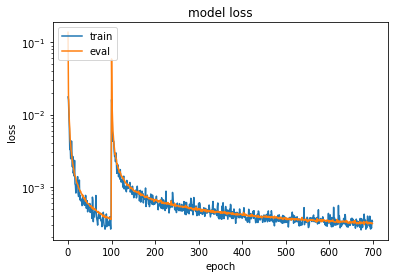

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\5.2_2597_zeiger1_2020-04-29_11-40-01.jpg 0.52 0.4550974396182144 0.0649025603817856
data_resize_all\5.2_2598_zeiger1_2020-04-29_14-18-02.jpg 0.52 0.4675185180788365 0.05248148192116353
data_resize_all\9.0_4438_zeiger1_2020-04-29_13-26-28.jpg 0.9 0.9525900680033221 -0.05259006800332211
data_resize_all\9.1_4547_zeiger2_2020-04-29_13-50-02.jpg 0.9099999999999999 0.969958465923196 -0.05995846592319609
data_resize_all\9.4.jpg 0.9400000000000001 1.0402779385859022 -0.10027793858590217
data_resize_all\9.6.jpg 0.96 1.0375737599717882 -0.07757375997178828


## Results

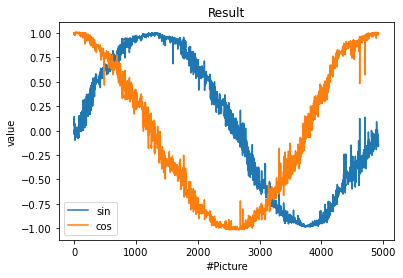

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

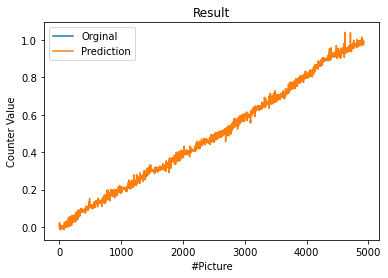

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

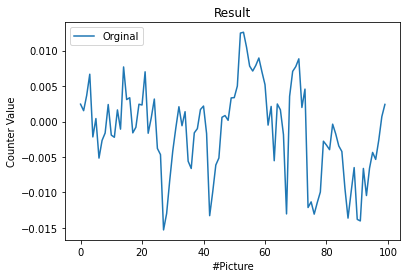

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

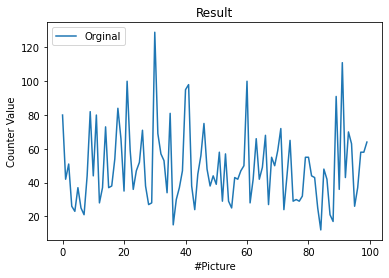

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

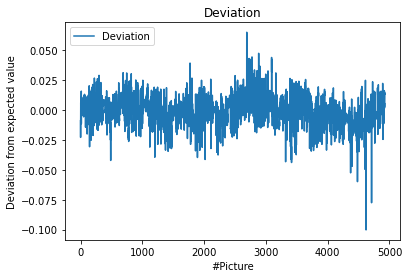

[-0.001   0.0114 -0.1003  0.0649]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

100772

In [15]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 32, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter2.inference_input_type = tf.int8  # or tf.uint8
converter2.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

33296